In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
import math
import tensorflow.keras as keras

## Chargement des données
On utilisera ici l'excellent OpenData public.opendatasoft.com, qui nous met gentiement à disposition des données météorologiques pour la région parisienne.

In [103]:
data_url = "https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/download/?format=csv&refine.nom_epci=M%C3%A9tropole+du+Grand+Paris&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"

In [104]:
data = pd.read_csv(data_url, sep=";")
data = data.sort_values("Date")

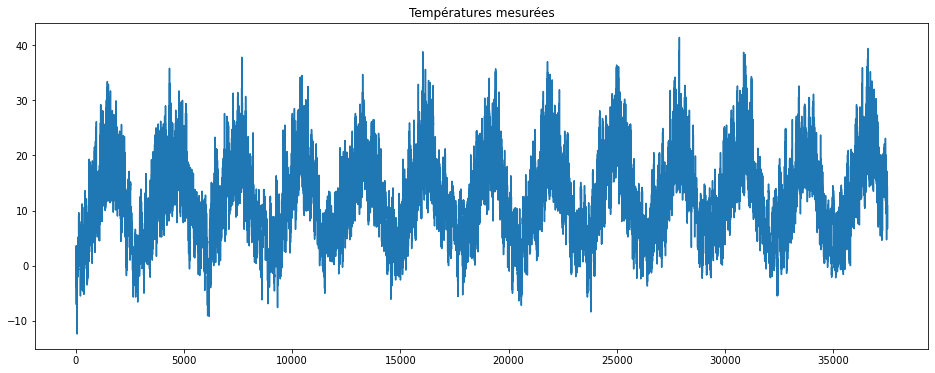

In [105]:
plt.figure(figsize=(16,6))
plt.title("Températures mesurées")

number = len(data)
plt.plot(data["Température (°C)"][0:number].values)

# Modèle basé sur la date
La date est encodé avec du "one-hot encoder". On utilise :
- le mois
- l'année
- l'heure

On a donc un vecteur de taille 12 + 1 + 24 = 37

In [106]:
x1, y = [], []

for i in range(3, len(data)):
    
    date = datetime.datetime.strptime(data["Date"][i].split("+")[0], '%Y-%m-%dT%H:%M:%S')
    date_vect = np.zeros(37)
    date_vect[date.month] = 1.0
    date_vect[date.hour + 12] = 1.0
    date_vect[36] = date.year-2000

    tmp = float(data["Température (°C)"][i])

    if not math.isnan(tmp):
        x1.append(date_vect)
        y.append(tmp)

x1 = np.array(x1)
y = np.array(y)

print(len(x1))
print(np.mean(y), np.std(y))

37515
12.382622950819696 7.291674182181488


In [107]:
from sklearn.linear_model import LinearRegression

split = int(len(x1) * 0.8)
x_train, x_test = x1[0:split], x1[split:len(x1)]
y_train, y_test = y[0:split], y[split:len(x1)]

modl1 = LinearRegression().fit(x_train, y_train)

print("r2 -> train", modl1.score(x_train, y_train))
print("r2 -> test", modl1.score(x_test, y_test))

r2 -> train 0.7221826938199061
r2 -> test 0.7383115481798026


# Modèle Date + auto-regressif
On ajoute à l'encodage de la date les précedentes valeurs mesurées + les encodages des horaires de mesures de celles-ci.

In [108]:
x, y = [], []
window_size = 50

use_prev = True

def norm_temp(tmp):
    return (tmp - 12) / 7

def de_norm(tmp):
    return tmp * 7 + 12

for i in range(3, len(data)):
    
    date = datetime.datetime.strptime(data["Date"][i].split("+")[0], '%Y-%m-%dT%H:%M:%S')
    date_vect = np.zeros(86 if use_prev else 37)
    date_vect[date.month] = 1.0
    date_vect[date.hour + 12] = 1.0
    date_vect[36] = date.year-2000

    tmp = norm_temp(float(data["Température (°C)"][i]))

    if use_prev:
        prev_date = datetime.datetime.strptime(data["Date"][i-1].split("+")[0], '%Y-%m-%dT%H:%M:%S')
        date_vect[37] = norm_temp(data["Température (°C)"][i-1])
        date_vect[38+prev_date.hour] = 1.0
        prev_date = datetime.datetime.strptime(data["Date"][i-2].split("+")[0], '%Y-%m-%dT%H:%M:%S')
        date_vect[62] = norm_temp(data["Température (°C)"][i-2])
        date_vect[62+prev_date.hour] = 1.0
        
        if not math.isnan(tmp) and not math.isnan(date_vect[37]) and not math.isnan(date_vect[62]):
            x.append(date_vect)
            y.append([tmp])
    
    else:
        if not math.isnan(tmp):
            x.append(date_vect)
            y.append([tmp])

x = np.array(x)
y = np.array(y)
print(len(x))
print(np.mean(y), np.std(y))

37513
0.0545982154757812 1.041635440919646


In [109]:
split = int(len(x) * 0.8)
x_train, x_test = x[0:split], x[split:len(x)]
y_train, y_test = y[0:split], y[split:len(x)]

In [110]:
from sklearn.linear_model import LinearRegression

modl = LinearRegression().fit(x_train, y_train)

print("r2 -> train", modl.score(x_train, y_train))
print("r2 -> test", modl.score(x_test, y_test))

r2 -> train 0.742812403522549
r2 -> test 0.7552248734678974


In [111]:
mse = np.mean(np.abs((y+12)*7 - (modl.predict(x)+12)*7))
print("erreur moyenne :", mse)

erreur moyenne : 2.9214529191078347


In [134]:
model = keras.Sequential()
model.add(keras.layers.Dense(12, activation="relu", input_shape=(len(x[0]),)))
model.add(keras.layers.Dense(8, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    decay_rate=0.99)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='mse', optimizer=opt)

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 12)                1044      
                                                                 
 dense_76 (Dense)            (None, 8)                 104       
                                                                 
 dense_77 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,157
Trainable params: 1,157
Non-trainable params: 0
_________________________________________________________________


Epoch 1/75
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
202/235 [========================>.....] - ETA: 0s - loss: 0.4445WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022A1B8B64C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

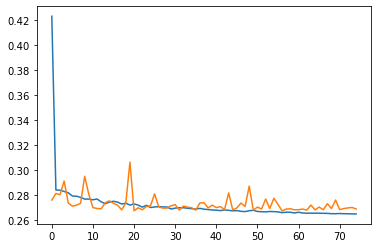

In [135]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=75, validation_data=(x_test, y_test))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [136]:
mse = np.mean(np.abs((y+12)*7 - (model.predict(x)+12)*7))
print("mean_error", mse)

from sklearn.metrics import r2_score

print("r2 train: ", r2_score(y_train, model.predict(x_train)))
print("r2 test: ", r2_score(y_test, model.predict(x_test)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
mean_error 2.867465006011457
r2 train:  0.7537039808158745
r2 test:  0.7582882222613178


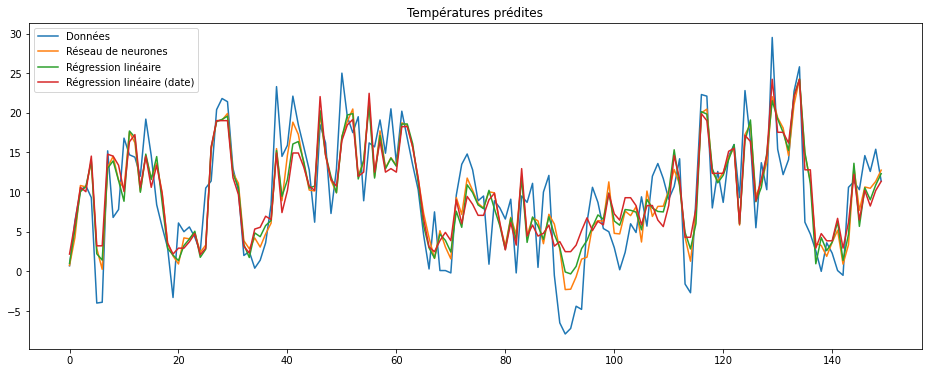

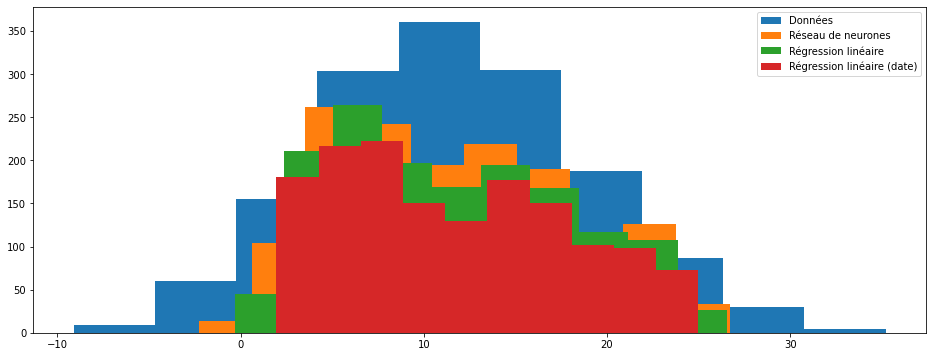

In [119]:
plt.figure(figsize=(16,6))
plt.title("Températures prédites")

number = 150
plt.plot(de_norm(y_train[0:number]), label="Données")
plt.plot(de_norm(model.predict(x_train[0:number])), label="Réseau de neurones")
plt.plot(de_norm(modl.predict(x_train[0:number])), label="Régression linéaire")
plt.plot(modl1.predict(x1[0:number]), label="Régression linéaire (date)")
plt.legend()
plt.show()


number = 1500
plt.figure(figsize=(16,6))
plt.hist(de_norm(y_train[0:number]), label="Données")
plt.hist(de_norm(model.predict(x_train[0:number])), label="Réseau de neurones")
plt.hist(de_norm(modl.predict(x_train[0:number])), label="Régression linéaire")
plt.hist(modl1.predict(x1[0:number]), label="Régression linéaire (date)")
plt.legend()
plt.show()

On constate que tous les modèles ont une variance plus faible que les données réelles, et peinent à prédire les valeurs extrêmes.